In [14]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import audiomentations
from torch_audiomentations import Compose, PitchShift, TimeInversion, AddBackgroundNoise, AddColoredNoise, PolarityInversion
import torchaudio
import numpy as np
import sys
import matplotlib.pyplot as plt
import tensorboard
from torch.utils.tensorboard import SummaryWriter

WRITER_PATH ="../../logs/CRNNA"

# Building the Cough Dataset

This is the preprocessing pipeline for all audio samples in the audio dataset.

In [6]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio

class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 target_sample_rate,
                 num_samples,
                 device,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'symptomatic':1, 'COVID-19':1}
        self.label_weights = self._calculate_weights(annotations_df)


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)
        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        if "symptomatic" == self._get_audio_sample_label(index):
            raise ValueError

        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path


    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]

    def _calculate_weights(self, annotation_df):
        counts = annotation_df["status"].value_counts()
        total = len(annotation_df)
        weights = (1-(counts/total))
        weights /= weights.sum()
        return torch.FloatTensor(weights)

# Oversampled Dataset

In [8]:
AUDIO_DIR = "../../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_3500.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_3500.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_3500.parquet.gzip"))

# Normal (3 Class) Dataset

In [6]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_edited.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_edited.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_edited.parquet.gzip"))

# CRNN Model

In [9]:
class CRNN(torch.nn.Module):
    def __init__(self, batch_size=16, drop_p=0.0):
        super().__init__()
        channels = [1, 16, 32, 64, 128]
        #hidden_state = [2]
        # 4 conv blocks / flatten / linear / softmax

        self.num_layers = 1
        self.hidden_size = 256
        self.embed_size = self.hidden_size * 2
        self.source_sequence_length = 31
        self.target_sequence_length = 1
        self.batch_size = batch_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = channels[0],
                out_channels = channels[1],
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(channels[1]),
            nn.Dropout(p=drop_p)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = channels[1],
                out_channels = channels[2],
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(channels[2]),
            nn.Dropout(p=drop_p)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = channels[2],
                out_channels = channels[3],
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(channels[3]),
            nn.Dropout(p=drop_p)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels = channels[3],
                out_channels = channels[4],
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(channels[4]),
            nn.Dropout(p=drop_p)
        )
        

        # LSTM Section
        self.LSTM_model = nn.LSTM(input_size=1024, hidden_size=256, bidirectional=True, batch_first=True)
        self.Tanh = nn.Tanh()
        
        # Transition from attention to FC

        self.linear_temporal = nn.Sequential(
            nn.Linear(self.source_sequence_length, 1),
            nn.ReLU()
        )

        # For Fully Connected Layer
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.hidden_size * 2, 2)
        self.softmax = nn.Softmax(dim=-1)
        # self.linear = nn.Linear(self.embed_size, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input_data):
        #nomralization
        std = input_data.std()
        input_data -= input_data.mean()
        input_data /= std
        
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #td = self.flatten(x)

        # Preprocessing for the LSTM
        td = torch.swapaxes(x, 1, 3) # [batch_size, 128, 8, 31]  --> [batch_size, 31, 8, 128]
        td = torch.reshape(td, (td.shape[0], 31, -1)) # 128 channels * 8 height of each channel = 1024

         # LSTM Section - Preparing for the LSTM
        self.h_0 = nn.Parameter(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size)).to(device) #hidden state
        self.c_0 = nn.Parameter(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_size)).to(device) #internal state
        
        # LSTM
        LSTM_output, (hn, cn) = self.LSTM_model(td, (self.h_0, self.c_0)) #lstm with input, hidden, and internal state
        LSTM_output = self.Tanh(LSTM_output)
        #print("LSTM Output Size:", LSTM_output.size()) # [16, 31, 512]
        # LSTM_Output: (31, 512)

        # LSTM_output --> (512, 1)
        #attn_output = torch.transpose(attn_output, 0, 1) # (31, 512) --> (512, 31)
        #print("attn_output:", attn_output.size())
        attn_output = torch.swapaxes(LSTM_output, 1, 2)
        #print("attn_output after swap:", attn_output.size())
        crunch = self.linear_temporal(attn_output)

        # Final Fully Connnected Layer
        x = self.flatten(crunch)
        #x = torch.transpose(x, 0, 1)
        #print("X transposed:", x.size())
        logits = self.linear(x)
        #logits = x
        predictions = self.softmax(logits)
        #predictions = self.sigmoid(logits)

        return predictions
    

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
).to(device)

augmentations = Compose(
        transforms=[
            PitchShift(
                mode = "per_example",
                p=0.5,
                sample_rate=SAMPLE_RATE,
                output_type="tensor"
                ),
            TimeInversion(
                mode = "per_example",
                p=0.5,
                output_type="tensor"
            ),
            AddColoredNoise(
                mode = "per_example",
                p=0.5,
                sample_rate=SAMPLE_RATE,
                output_type="tensor"
            ),
            PolarityInversion(
                mode="per_example",
                p=0.5,
                output_type="tensor"
            ), 

        ], output_type="tensor"
    )

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, do_augment=False):
    total_loss_train = 0.0
    correct_pred_train = 0.0
    total_pred_train = 0

    train_trues = []
    train_preds = []

    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        if do_augment:
            x_batch = augmentations(x_batch, SAMPLE_RATE)
        

        x_batch = x_batch.reshape(-1, x_batch.shape[-1])
        x_batch = mel_spectrogram(x_batch)
        x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
        
        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        # add to list for f1 score
        train_trues.append(y_batch.cpu())
        train_preds.append(y_pred.cpu())
        
        correct_pred_train += count_correct(y_pred, y_batch)
        total_pred_train += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss_train += loss.item()

        
        
    print(f"Training loss: {total_loss_train}, Training accuracy : {correct_pred_train/total_pred_train}")
    #print normalized loss
    print(f"Training loss normalized: {total_loss_train/len(train_data_loader)}")
    # print f1 score, precision, recall
    # print(classification_report(torch.cat(train_trues).detach().cpu().numpy(), torch.argmax(torch.cat(train_preds), axis=1).detach().cpu().numpy()))
    
    total_loss_val = 0.0
    correct_pred_val = 0.0
    total_pred_val = 0

    val_trues = []
    val_preds = []

    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss_val += loss.item() 
            
            val_trues.append(y_batch.cpu())
            val_preds.append(y_pred.cpu())

        correct_pred_val += count_correct(y_pred, y_batch)
        total_pred_val += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss_val}, Validation accuracy : {correct_pred_val/total_pred_val}")
    #print normalized loss
    print(f"Validation loss normalized: {total_loss_val/len(val_data_loader)}")
    #print f1 score, confusion matrix and precision, recall using sklearn and true and predicted values
    # print(classification_report(torch.cat(val_trues).detach().cpu().numpy(), torch.argmax(torch.cat(val_preds), axis=1).detach().cpu().numpy()))
    return total_loss_train/len(train_data_loader), correct_pred_train/total_pred_train, total_loss_val/len(val_data_loader), correct_pred_val/total_pred_val


    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs, do_augment):
    writer = SummaryWriter(WRITER_PATH)
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_loss, train_acc, val_loss, val_acc = train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        writer.add_scalar("train/accuracy", train_acc, i)
        writer.add_scalar("train/loss", train_loss, i)
        writer.add_scalar("validation/accuracy", val_acc, i)
        writer.add_scalar("validation/loss", val_loss, i)
        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")

    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")

    trues = []
    preds =[]

    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()

            trues += torch.clamp(y_batch, max=1)
            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)    

    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    # print normalized loss
    print(f"Evaluation loss normalized: {total_loss/len(eval_data_loader)}")
    print("---------------------------")        
            
    return np.array(trues), np.array(preds)
        

In [13]:
BATCH_SIZE = 256
EPOCHS = 50
MODEL_FOLDER = '../../models/CRNNA'

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        )
print('train data: ', train_data)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,drop_last=True) 
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE,drop_last=True) 
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,drop_last=True) 

# construct model and assign it to device
model = CRNN(batch_size = BATCH_SIZE).to(device)

# initialise loss funtion + optimiser
#loss_fn = nn.CrossEntropyLoss(weight=train_data.label_weights)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-5)

train data:  <__main__.CoughDataset object at 0x2a82779a0>


In [15]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS, do_augment=True)

Epoch 1


100%|██████████| 24/24 [01:02<00:00,  2.58s/it]


Training loss: 16.62392634153366, Training accuracy : 0.5564778447151184
Training loss normalized: 0.6926635975639025


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Validataion loss: 2.0717450976371765, Validation accuracy : 0.7877604365348816
Validation loss normalized: 0.6905816992123922
Saved at ../../models/CRNNA/epoch_0.pth
---------------------------
Epoch 2


100%|██████████| 24/24 [01:02<00:00,  2.61s/it]


Training loss: 16.608417689800262, Training accuracy : 0.5716145634651184
Training loss normalized: 0.6920174037416776


100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Validataion loss: 2.0654884576797485, Validation accuracy : 0.8059895634651184
Validation loss normalized: 0.6884961525599161
Saved at ../../models/CRNNA/epoch_1.pth
---------------------------
Epoch 3


100%|██████████| 24/24 [01:03<00:00,  2.66s/it]


Training loss: 16.592859029769897, Training accuracy : 0.5817057490348816
Training loss normalized: 0.6913691262404124


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Validataion loss: 2.057356894016266, Validation accuracy : 0.8255208134651184
Validation loss normalized: 0.6857856313387553
Saved at ../../models/CRNNA/epoch_2.pth
---------------------------
Epoch 4


100%|██████████| 24/24 [01:03<00:00,  2.65s/it]


Training loss: 16.575126588344574, Training accuracy : 0.5869140625
Training loss normalized: 0.6906302745143572


100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Validataion loss: 2.0469892621040344, Validation accuracy : 0.8385416865348816
Validation loss normalized: 0.6823297540346781
Saved at ../../models/CRNNA/epoch_3.pth
---------------------------
Epoch 5


100%|██████████| 24/24 [01:01<00:00,  2.56s/it]


Training loss: 16.55494922399521, Training accuracy : 0.5896809697151184
Training loss normalized: 0.6897895509998003


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


Validataion loss: 2.034457564353943, Validation accuracy : 0.8489583134651184
Validation loss normalized: 0.6781525214513143
Saved at ../../models/CRNNA/epoch_4.pth
---------------------------
Epoch 6


100%|██████████| 24/24 [01:02<00:00,  2.60s/it]


Training loss: 16.533646941184998, Training accuracy : 0.5914713740348816
Training loss normalized: 0.6889019558827082


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Validataion loss: 2.021250307559967, Validation accuracy : 0.8541666865348816
Validation loss normalized: 0.673750102519989
Saved at ../../models/CRNNA/epoch_5.pth
---------------------------
Epoch 7


100%|██████████| 24/24 [01:01<00:00,  2.58s/it]


Training loss: 16.511882603168488, Training accuracy : 0.5939127802848816
Training loss normalized: 0.6879951084653536


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Validataion loss: 2.0079256296157837, Validation accuracy : 0.85546875
Validation loss normalized: 0.6693085432052612
Saved at ../../models/CRNNA/epoch_6.pth
---------------------------
Epoch 8


100%|██████████| 24/24 [01:03<00:00,  2.64s/it]


Training loss: 16.48981499671936, Training accuracy : 0.5930989384651184
Training loss normalized: 0.6870756248633066


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Validataion loss: 1.994690179824829, Validation accuracy : 0.8567708134651184
Validation loss normalized: 0.6648967266082764
Saved at ../../models/CRNNA/epoch_7.pth
---------------------------
Epoch 9


100%|██████████| 24/24 [01:03<00:00,  2.63s/it]


Training loss: 16.46759259700775, Training accuracy : 0.5945637822151184
Training loss normalized: 0.6861496915419897


100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Validataion loss: 1.9813478589057922, Validation accuracy : 0.8567708134651184
Validation loss normalized: 0.6604492863019308
Saved at ../../models/CRNNA/epoch_8.pth
---------------------------
Epoch 10


100%|██████████| 24/24 [01:03<00:00,  2.65s/it]


Training loss: 16.444919168949127, Training accuracy : 0.59765625
Training loss normalized: 0.6852049653728803


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Validataion loss: 1.9681947827339172, Validation accuracy : 0.86328125
Validation loss normalized: 0.6560649275779724
Saved at ../../models/CRNNA/epoch_9.pth
---------------------------
Epoch 11


100%|██████████| 24/24 [01:03<00:00,  2.63s/it]


Training loss: 16.422044813632965, Training accuracy : 0.599609375
Training loss normalized: 0.6842518672347069


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


Validataion loss: 1.9554871916770935, Validation accuracy : 0.8645833134651184
Validation loss normalized: 0.6518290638923645
Saved at ../../models/CRNNA/epoch_10.pth
---------------------------
Epoch 12


 38%|███▊      | 9/24 [00:24<00:40,  2.73s/it]

In [215]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

#set model to be the epoch 10 model in the models folder
#model.load_state_dict(torch.load('../models/epoch_9.pth'))

# evaluate model with test data using the loaded model
trues, preds = evaluate(model, test_dataloader, loss_fn, device)


Evaluating model


100%|██████████| 72/72 [00:10<00:00,  6.73it/s]

Evaluation loss: 57.29608428478241, Evaluation accuracy : 0.753484308719635
Evaluation loss normalized: 0.7957789483997557
---------------------------


In [216]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [235]:
from sklearn.metrics import plot_confusion_matrix

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
            
            y_pred = model(x_batch)

            trues += torch.clamp(y_batch, max=1)
            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)            
            
    return np.array(trues), np.array(preds)

In [236]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|██████████| 72/72 [00:11<00:00,  6.29it/s]


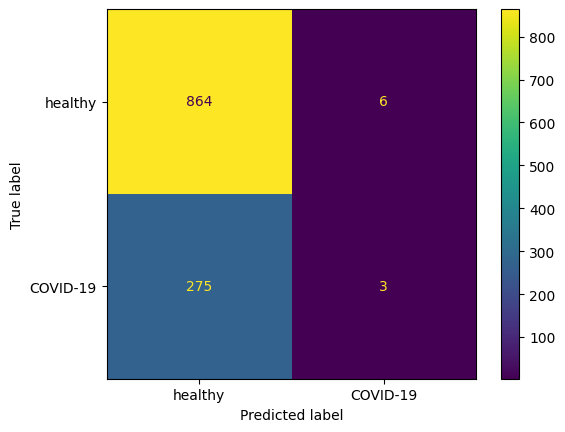

In [237]:
cfm = confusion_matrix(trues, preds)
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'COVID-19']).plot()

              precision    recall  f1-score   support

           0       0.58      0.68      0.63       315
           1       0.61      0.50      0.55       315

    accuracy                           0.59       630
   macro avg       0.60      0.59      0.59       630
weighted avg       0.60      0.59      0.59       630

f1:  0.5886965865703377
roc:  0.5920634920634921


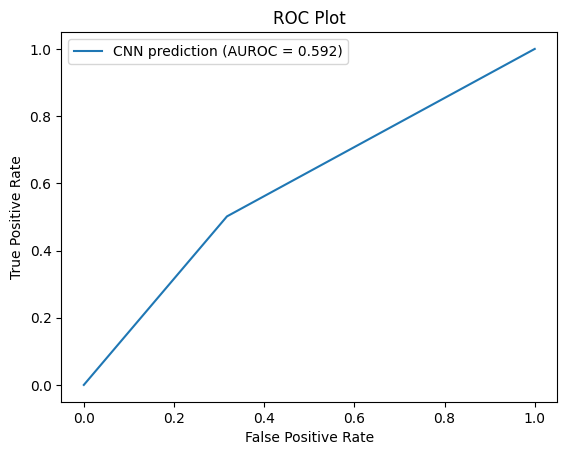

In [192]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(trues, preds))

# calculate f1 score
from sklearn.metrics import f1_score
print('f1: ', f1_score(trues, preds, average='macro'))

#calculate and graph ROC AUC
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
r_auc = roc_auc_score(trues, preds)
print('roc: ', r_auc)

fpr, tpr, thresholds = roc_curve(trues, preds)
plt.plot(fpr, tpr, label='CNN prediction (AUROC = %0.3f)' % r_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()